Plots winrate of latest KataGo checkpoints,
starting from b40-s11840M (aka cp505)
and going until networks from 2023-03-14
(a few months after adversarial-position-selfplay started).

### Load libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportion_confint

import utils

plt.style.use(
    ["tableau-colorblind10", utils.get_style("default"), utils.get_style("1-col")]
)

### Parse data

In [2]:
df = utils.parse_sgfs(
    [
        "/nas/ucb/tony/go-attack/matches/cyclic-adv-s545m-vs-newer-katago-ckpts/",
        "/nas/ucb/k8/go-attack/match/tony-new-kata-cp-sweep-try0/",
        "/nas/ucb/k8/go-attack/match/tony-new-kata-cp-sweep-v32/",
    ]
)
df["victim_net_type"] = df.victim_name.str.split("-").str[0]
df["victim_rows"] = df.victim_name.str.split("-d").str[-1].astype(int)
len(df), df.victim_visits.unique()

(10700, array([200,   1,  32]))

In [3]:
# kata1-b60c320-s6729327872-d3057177418 is last checkpoint before
# adversarial training begins
ADV_TRAIN_ROW_START = 3057177418

# Latest - kata1-b40c256-s11840935168-d2898845681 
LATEST_STEPS = 11840935168

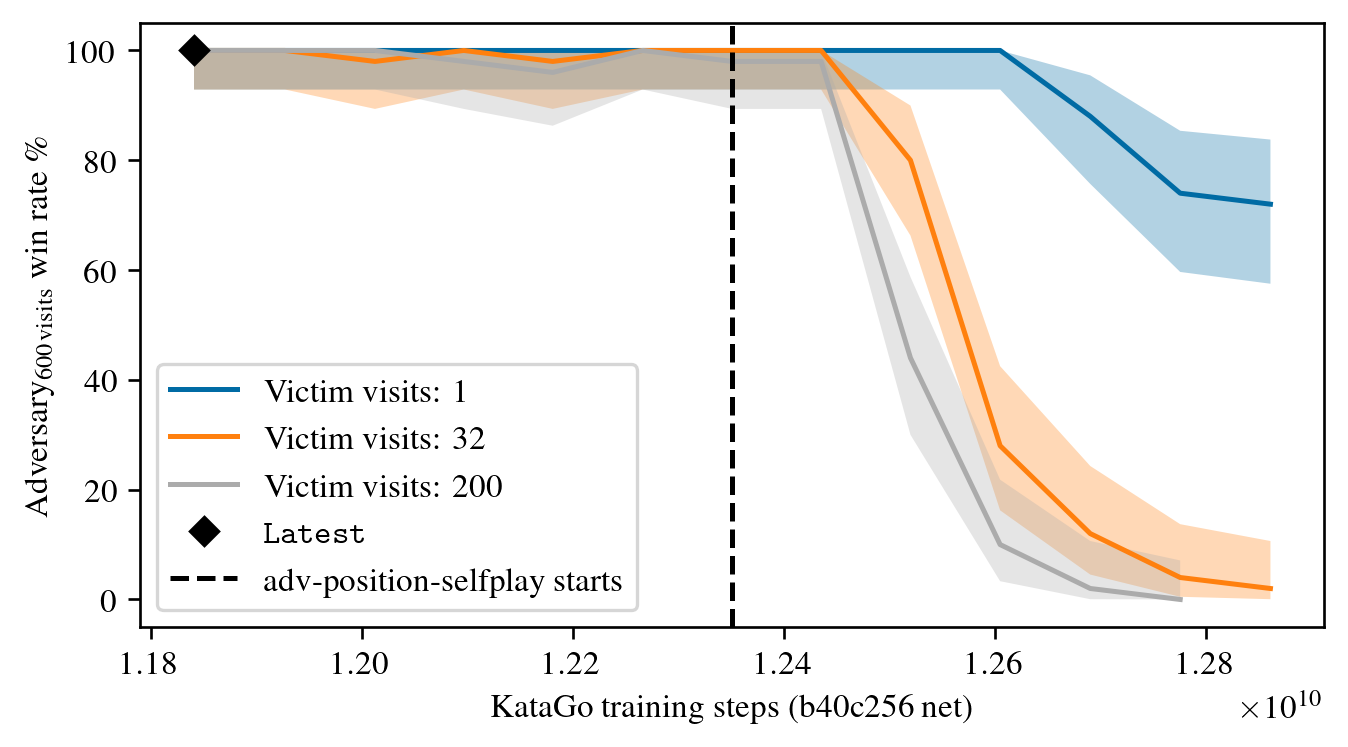

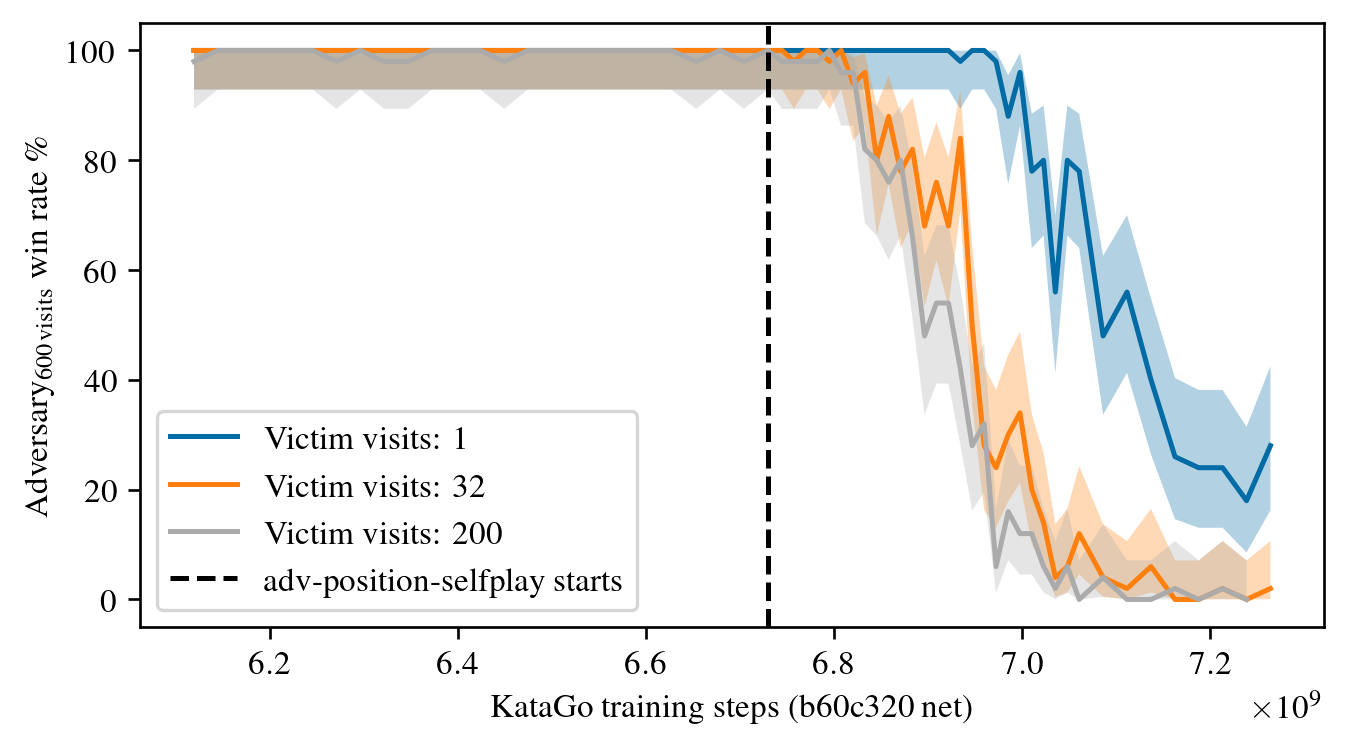

In [4]:
ALPHA = 0.05
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for net_type in sorted(df.victim_net_type.unique()):
    for i, vv in enumerate(sorted(df.victim_visits.unique())):
        cdf = df.query("victim_net_type == @net_type and victim_visits == @vv")
        mean_df = cdf.groupby("victim_steps").adv_win.mean()

        (100 * mean_df).plot(label=f"Victim visits: {vv}", color=colors[i])

        # Compute clopper-pearson confidence intervals
        ci_df = cdf.groupby("victim_steps").adv_win.apply(
            lambda x: proportion_confint(
                x.sum(),
                len(x),
                alpha=ALPHA,
                method="beta",
            )
        )
        ci_df = pd.DataFrame(
            ci_df.tolist(), index=ci_df.index, columns=["lower", "upper"]
        )
        ci_df = 100 * ci_df
        plt.fill_between(
            mean_df.index,
            ci_df.lower,  # type: ignore
            ci_df.upper,  # type: ignore
            alpha=0.3,
            color=colors[i],
            edgecolor="none",
        )

        if vv == 200:
            if net_type == "b40c256":
                plt.plot(
                    LATEST_STEPS,
                    100 * cdf.query("victim_steps == @LATEST_STEPS").adv_win.mean(),
                    "D",
                    label=r"\texttt{Latest}",
                    color="black",
                )

            adv_training_start_steps = cdf.query(
                "victim_rows <= @ADV_TRAIN_ROW_START"
            ).victim_steps.max()
            plt.axvline(
                adv_training_start_steps,
                color="black",
                linestyle="--",
                label="adv-position-selfplay starts",
            )

    # Legend in lower left corner
    plt.legend(loc="lower left")
    plt.ylabel(r"Adversary$_\mathrm{600\,visits}$ win rate \%")
    plt.xlabel(rf"KataGo training steps ({net_type} net)")
    plt.show()